**Домашнее задание**

Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
Повторить п.2, но используя уже не медиану, а max
(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd

#### Новости

In [2]:
news = pd.read_csv("P:/Обучение/Машинное обучение в бизнесе/lection2_materials/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


#### Пользователи и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("P:/Обучение/Машинное обучение в бизнесе/lection2_materials/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Нам необходимо получить векторные представления пользователей на основе прочитанных ими новостей и самих новостей

In [4]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов

import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
!pip install razdel

# pip install pymorphy2
import pymorphy2

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I-One\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('P:/Обучение/Машинное обучение в бизнесе/lection2_materials/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
   
    #очистка текста
    
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str`, то преобразуем его в `str`
        [1] токенизация предложения через razdel
        [2] проверка наличия символа '-' в начале слова 
        [3] проверка токена с одного символа
        [4] проверка на наличие данного слова в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
#Запуск очистки текста

news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-2b6c282390e3>:12: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


In [11]:
#Запуск лемматизации текста.

news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив их на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [14]:
from gensim.models import LdaModel

In [15]:
from gensim.models import LdaModel

lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [16]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [17]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(1, 0.06884246),
 (4, 0.026042601),
 (7, 0.08154001),
 (12, 0.36178753),
 (14, 0.15562814),
 (16, 0.15372153),
 (24, 0.13636655)]

In [18]:
x = lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: который это страна год россия свой мочь
topic_1: год это новый проект система развитие научный
topic_2: район авария обращение вода городской автомобиль край
topic_3: украина украинский киев граница это писать россия
topic_4: дональд восток временной климат писать польша польский
topic_5: год россия это nn фонд область технология
topic_6: газ год ноябрь январь декабрь канал тыс
topic_7: операция пациент террорист боевик соцсеть бомба брюссель
topic_8: год продукция мужчина задержать британский летний кость
topic_9: год который это человек исследование весь стать
topic_10: nn погибнуть путин президент россия владимир белоруссия
topic_11: год высота китай китайский nn млн фильм
topic_12: это всё первый очень мочь планета большой
topic_13: мозг смерть разместить характерный полоса евро ск
topic_14: греция тур саммит болгария нулевой греческий олимпийский
topic_15: лауреат лицензия су выручка ким приобретать жир
topic_16: возраст год жизнь свой который жить это
topic_17: компания 

Теперь напишем функцию, возвращающую векторное представление новости 

In [19]:
text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [20]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(7)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.064042,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.875961,0.0,0.0,0.0,0.000000
1,4896,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.048213,0.000000,0.0,0.0,0.0,0.691022
2,4897,0.000000,0.069278,0.000000,0.000000,0.026044,0.000000,0.000000,0.081766,0.00000,...,0.0,0.154290,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.135281
3,4898,0.076744,0.000000,0.000000,0.000000,0.000000,0.000000,0.018467,0.000000,0.00000,...,0.0,0.136545,0.0,0.0,0.073123,0.000000,0.0,0.0,0.0,0.000000
4,4899,0.000000,0.000000,0.342663,0.000000,0.000000,0.432635,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
5,4900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.07333,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
6,4901,0.000000,0.000000,0.550114,0.059549,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


Теперь, когда у нас есть вектора наших новостей, перейдём к векторным представлением пользователей.

#### Пользователи

In [21]:
users.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [22]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))
doc_dict

{6: array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.06404196, 0.        , 0.        , 0.        , 0.01138829,
        0.        , 0.        , 0.        , 0.        , 0.04121266,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.87596101, 0.        , 0.        , 0.        , 0.        ]),
 4896: array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.23875383,
        0.        , 0.        , 0.        , 0.        , 0.04821349,
        0.        , 0.        , 0.        , 0.        , 0.6910218 ]),
 4897: array([0.        , 0.06927762, 0.        , 0.        , 0.02604446,
        0.        , 0.        , 0.08176581, 0.        , 0.        ,
        0.        , 0.        , 0.36167347, 0.        , 0.15559669,
        0.        , 0.15428993, 0.        , 0.        , 0.        ,
        0.        , 0.       

In [23]:
def get_user_embedding(user_articles_list, turn='mean'):
    
    user_articles_list = eval(user_articles_list)
    # раскрытие тем для пользователя
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if turn == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif turn == 'median':
        user_vector = np.median(user_vector, 0)
    elif turn == 'max':
        user_vector = np.max(user_vector, 0)
    return user_vector

In [24]:
user_articles_list = users['articles'].iloc[33]
get_user_embedding(user_articles_list, turn='median')

array([0.33097903, 0.03430714, 0.        , 0.        , 0.        ,
       0.05300037, 0.        , 0.        , 0.        , 0.1268045 ,
       0.04462587, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01312325, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Далее получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [25]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, turn='max'), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(5)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.433995,0.233826,0.097142,0.247842,0.000000,0.535646,0.125749,0.067142,0.149067,...,0.0,0.158052,0.206300,0.000000,0.041340,0.136282,0.061205,0.0,0.173429,0.201582
1,u108690,0.558190,0.174495,0.122309,0.174806,0.000000,0.102500,0.000000,0.019165,0.047146,...,0.0,0.052439,0.015622,0.000000,0.244719,0.212550,0.012197,0.0,0.012335,0.125081
2,u108339,0.648921,0.022600,0.069313,0.000000,0.015385,0.230290,0.050275,0.053849,0.066516,...,0.0,0.013529,0.055458,0.021926,0.163245,0.130743,0.036875,0.0,0.015969,0.267578
3,u101138,0.346310,0.246735,0.000000,0.095795,0.000000,0.011967,0.000000,0.000000,0.126517,...,0.0,0.452149,0.000000,0.000000,0.000000,0.000000,0.163267,0.0,0.151386,0.250096
4,u108248,0.465169,0.062713,0.068939,0.290840,0.027703,0.123353,0.262697,0.000000,0.099294,...,0.0,0.123619,0.030728,0.000000,0.075246,0.025267,0.014258,0.0,0.014173,0.117460


**Можно попробовать обучить модель**

In [26]:
target = pd.read_csv("P:/Обучение/Машинное обучение в бизнесе/lection2_materials/users_churn.csv")
target.head(5)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [27]:
X = pd.merge(user_embeddings, target, 'left')
X.head(5)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.433995,0.233826,0.097142,0.247842,0.000000,0.535646,0.125749,0.067142,0.149067,...,0.158052,0.206300,0.000000,0.041340,0.136282,0.061205,0.0,0.173429,0.201582,0
1,u108690,0.558190,0.174495,0.122309,0.174806,0.000000,0.102500,0.000000,0.019165,0.047146,...,0.052439,0.015622,0.000000,0.244719,0.212550,0.012197,0.0,0.012335,0.125081,1
2,u108339,0.648921,0.022600,0.069313,0.000000,0.015385,0.230290,0.050275,0.053849,0.066516,...,0.013529,0.055458,0.021926,0.163245,0.130743,0.036875,0.0,0.015969,0.267578,1
3,u101138,0.346310,0.246735,0.000000,0.095795,0.000000,0.011967,0.000000,0.000000,0.126517,...,0.452149,0.000000,0.000000,0.000000,0.000000,0.163267,0.0,0.151386,0.250096,0
4,u108248,0.465169,0.062713,0.068939,0.290840,0.027703,0.123353,0.262697,0.000000,0.099294,...,0.123619,0.030728,0.000000,0.075246,0.025267,0.014258,0.0,0.014173,0.117460,1


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# разделим данные
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=42)

In [30]:
# обучим регрессию
logreg = LogisticRegression() 
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
# наши прогнозы на тесте
preds = logreg.predict_proba(X_test)[:, 1]
preds[:16]

array([3.89460093e-06, 5.48230115e-04, 3.67309699e-03, 3.90091651e-02,
       3.66824814e-01, 2.35981672e-01, 4.21233701e-05, 1.20986828e-02,
       3.59654014e-01, 1.35113792e-01, 6.59981205e-04, 4.65280278e-02,
       1.36773010e-02, 2.04842396e-02, 1.39153850e-02, 2.71369806e-03])

In [32]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_score, precision_recall_curve, classification_report

*Рассчитаем Precision, Recall, F_score*

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.286001, F-Score=0.752, Precision=0.707, Recall=0.802


In [34]:
# Визуализируем матрицу ошибок

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
import itertools

Confusion matrix, without normalization
[[1663   84]
 [  51  202]]


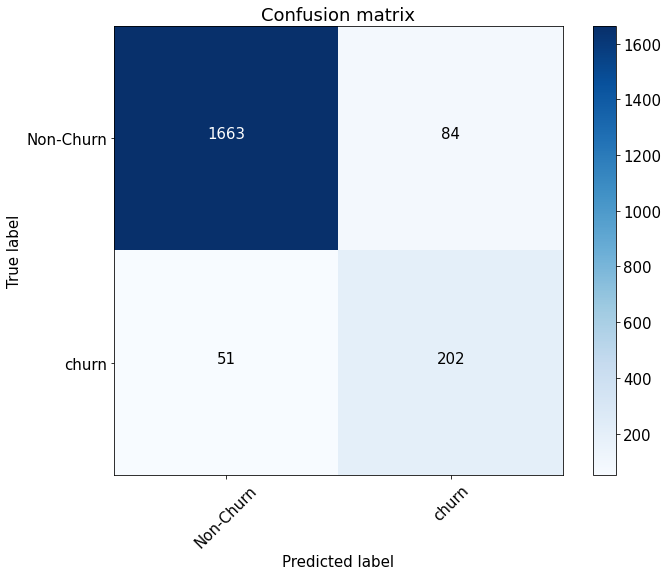

In [36]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [37]:
roc_auc_score(y_test, preds)

0.9678862239276365

В этом примере наибольший эффект приносит метод свертки тональностей, ориентированный на максимальные значения, что означает, что наибольший вес играют наиболее употребимые термины в данной тональности.